Import Libraries

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


import keras_tuner as kt

Load & Preprocess Data

In [26]:
# Load and process the datasets
train = pd.read_csv('datasets/tabular_train_data.csv')
val = pd.read_csv('datasets/tabular_validation_data.csv')

In [ ]:
# Split features and labels for training and validation sets
X_train = train.drop(['outcome'], axis=1)
Y_train = train['outcome']
X_val = val.drop(['outcome'], axis=1)
Y_val= val['outcome']

In [ ]:
# Display dataset dimensions and feature overview for debugging
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"y_val shape: {Y_val.shape}")
print("X_train columns:", X_train.columns.tolist())
print("X_train head:", X_train.head())
print(f"X_train.shape[1]: {X_train.shape[1]}")

X_train shape: (1587, 8)
X_val shape: (397, 8)
y_train shape: (1587,)
y_val shape: (397,)
X_train columns: ['num_bids', 'num_countries', 'num_merchandise', 'num_urls', 'num_ips', 'num_devices', 'num_auctions', 'total_duration']
X_train head:    num_bids  num_countries  num_merchandise  num_urls   num_ips  num_devices  \
0 -0.104165      -0.397105        -0.022456 -0.125941 -0.138027    -0.349536   
1 -0.105254      -0.525142        -0.022456 -0.128930 -0.140742    -0.413474   
2 -0.091034       0.072365        -0.022456 -0.106885 -0.103366    -0.008537   
3 -0.067357       0.115044        -0.022456 -0.039255 -0.106498     0.103353   
4 -0.105254      -0.525142        -0.022456 -0.128930 -0.140742    -0.413474   

   num_auctions  total_duration  
0     -0.350281       -0.558650  
1     -0.418184       -0.971009  
2      0.091087       -0.559244  
3     -0.051509       -0.557226  
4     -0.418184       -0.971009  
X_train.shape[1]: 8


Build FNN model

In [29]:
def build_fnn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        AUC(name='auc')
    ]
    )
    return model

print("\nBuilding FNN model...")
model = build_fnn(X_train.shape[1])
model.summary()


Building FNN model...


c:\Users\Michelle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights based on training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train 
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.5251489080079418, 1: 10.44078947368421}


Train Model

In [31]:
print("\nTraining model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)



Training model...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5269 - auc: 0.6203 - loss: 0.7763 - precision: 0.0680 - recall: 0.7091 - val_accuracy: 0.8640 - val_auc: 0.7466 - val_loss: 0.6024 - val_precision: 0.0645 - val_recall: 0.0741
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - auc: 0.7085 - loss: 0.7091 - precision: 0.0903 - recall: 0.6884 - val_accuracy: 0.9118 - val_auc: 0.6857 - val_loss: 0.5643 - val_precision: 0.1667 - val_recall: 0.0741
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5802 - auc: 0.6819 - loss: 0.6728 - precision: 0.0739 - recall: 0.7083 - val_accuracy: 0.9219 - val_auc: 0.6335 - val_loss: 0.5368 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6199 - auc: 0.6860 - loss: 0.6619 - precision: 0.0834 - recall: 0.6737 - val_accuracy: 0.9093 - val_auc: 0.7630 - val_loss: 0.5235 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


Evaluation

In [32]:
print("\nEvaluating model...")
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
metrics = {
    'AUC-ROC': roc_auc_score(Y_val, y_pred_proba),
    'Precision': precision_score(Y_val, y_pred),
    'Recall': recall_score(Y_val, y_pred),
    'F1 Score': f1_score(Y_val, y_pred)
}

# Print metrics
print("\nPerformance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(Y_val, y_pred, target_names=['Human', 'Robot']))



Evaluating model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance Metrics:
AUC-ROC: 0.8269
Precision: 0.2289
Recall: 0.7037
F1 Score: 0.3455

Classification Report:
              precision    recall  f1-score   support

       Human       0.97      0.83      0.89       370
       Robot       0.23      0.70      0.35        27

    accuracy                           0.82       397
   macro avg       0.60      0.77      0.62       397
weighted avg       0.92      0.82      0.86       397




Confusion Matrix:
[[306  64]
 [  8  19]]


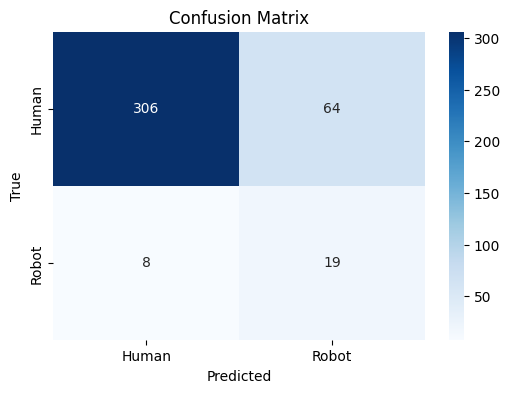

In [33]:
# Compute confusion matrix
cm = confusion_matrix(Y_val, y_pred)

print("\nConfusion Matrix:")
print(cm)

# Optional: plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Robot'], yticklabels=['Human', 'Robot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Perform tuning and get best model evalutation metrics and best model hyperparameters

In [ ]:
from tensorflow.keras.regularizers import l2

# Initialize best model tracking
best_model = model
best_metrics = metrics
best_avg = sum(metrics.values()) / len(metrics)
best_history = None
best_hyperparams = None

# Hyperparameter space
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
dropouts = [
    (0.3, 0.2, 0.1),  
    (0.2, 0.1, 0.05),
    (0.1, 0.05, 0.05) 
]

print("\nStarting tuning...")

for lr in learning_rates:
    for batch in batch_sizes:
        for d1, d2, d3 in dropouts:
            tuned_model = Sequential([
                Input(shape=(X_train.shape[1],)),
                Dense(128, activation='relu'),
                BatchNormalization(),
                Dropout(d1),

                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(d2),

                Dense(32, activation='relu'),
                BatchNormalization(),
                Dropout(d3),

                Dense(1, activation='sigmoid')
            ])
            tuned_model.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=[
                    'accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    AUC(name='auc')
                ]
            )

            # Callbacks
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model with class weights
            tuned_model.fit(
                X_train, Y_train,
                validation_data=(X_val, Y_val),
                epochs=100,
                batch_size=batch,
                callbacks=[early_stop],
                verbose=0,
                class_weight=class_weights  
            )

            # Evaluate
            y_pred_proba = tuned_model.predict(X_val, verbose=0).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            auc = roc_auc_score(Y_val, y_pred_proba)
            precision = precision_score(Y_val, y_pred)
            recall = recall_score(Y_val, y_pred)
            f1 = f1_score(Y_val, y_pred)
            avg = (auc + precision + recall + f1) / 4

            print(f"→ AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Avg: {avg:.4f}")

            if avg > best_avg:
                best_model = tuned_model
                best_metrics = {
                    'AUC-ROC': auc,
                    'Precision': precision,
                    'Recall': recall,
                    'F1 Score': f1
                }
                best_avg = avg
                best_hyperparams = {
                    'learning_rate': lr,
                    'batch_size': batch,
                    'dropout_rates': (d1, d2, d3)
                }
                print("New best model found!")

# Final best model evaluation
print("\nBest Model Metrics:")
for metric, val in best_metrics.items():
    print(f"{metric}: {val:.4f}")

print("\nBest Model Hyperparameters:")
for param, val in best_hyperparams.items():
    print(f"{param}: {val}")



Starting tuning...
→ AUC: 0.8386, Precision: 0.3256, Recall: 0.5185, F1: 0.4000, Avg: 0.5207
→ AUC: 0.8367, Precision: 0.2055, Recall: 0.5556, F1: 0.3000, Avg: 0.4744
→ AUC: 0.7994, Precision: 0.2533, Recall: 0.7037, F1: 0.3725, Avg: 0.5322
New best model found!
→ AUC: 0.8228, Precision: 0.2833, Recall: 0.6296, F1: 0.3908, Avg: 0.5316
→ AUC: 0.8274, Precision: 0.2656, Recall: 0.6296, F1: 0.3736, Avg: 0.5241
→ AUC: 0.7546, Precision: 0.1754, Recall: 0.7407, F1: 0.2837, Avg: 0.4886
→ AUC: 0.8029, Precision: 0.1798, Recall: 0.5926, F1: 0.2759, Avg: 0.4628
→ AUC: 0.8423, Precision: 0.2857, Recall: 0.7407, F1: 0.4124, Avg: 0.5703
New best model found!
→ AUC: 0.7678, Precision: 0.1538, Recall: 0.4444, F1: 0.2286, Avg: 0.3987
→ AUC: 0.7877, Precision: 0.1613, Recall: 0.3704, F1: 0.2247, Avg: 0.3860
→ AUC: 0.8206, Precision: 0.2321, Recall: 0.4815, F1: 0.3133, Avg: 0.4619
→ AUC: 0.7895, Precision: 0.2553, Recall: 0.4444, F1: 0.3243, Avg: 0.4534

Best Model Metrics:
AUC-ROC: 0.8423
Precision: 

In [48]:
print("\n Best Model Summary:")
best_model.summary()


 Best Model Summary:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,357 (142.02 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 23,940 (93.52 KB)

Training vs Validation Metrics

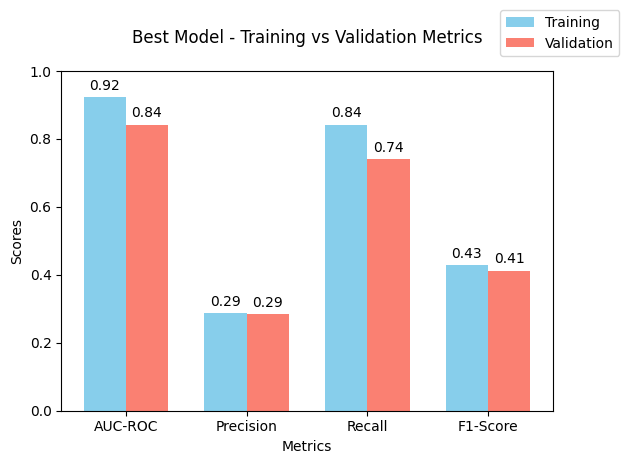

In [49]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Recalculate true metrics using best_model
# Validation
y_val_pred_proba = best_model.predict(X_val, verbose=0).flatten()
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

val_scores = [
    roc_auc_score(Y_val, y_val_pred_proba),
    precision_score(Y_val, y_val_pred),
    recall_score(Y_val, y_val_pred),
    f1_score(Y_val, y_val_pred)
]

# Training
y_train_pred_proba = best_model.predict(X_train, verbose=0).flatten()
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

train_scores = [
    roc_auc_score(Y_train, y_train_pred_proba),
    precision_score(Y_train, y_train_pred),
    recall_score(Y_train, y_train_pred),
    f1_score(Y_train, y_train_pred)
]

# Plot
metrics = ['AUC-ROC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_scores, width, label='Training', color='skyblue')
bars2 = ax.bar(x + width/2, val_scores, width, label='Validation', color='salmon')

ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

ax.set_ylabel('Scores')
ax.set_xlabel('Metrics')
ax.set_title('Best Model - Training vs Validation Metrics', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.2))

plt.tight_layout()
plt.show()


Confusion Matrix

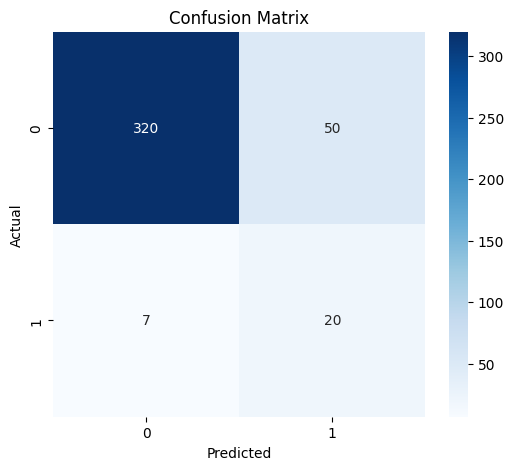

In [50]:
cm = confusion_matrix(Y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC curve

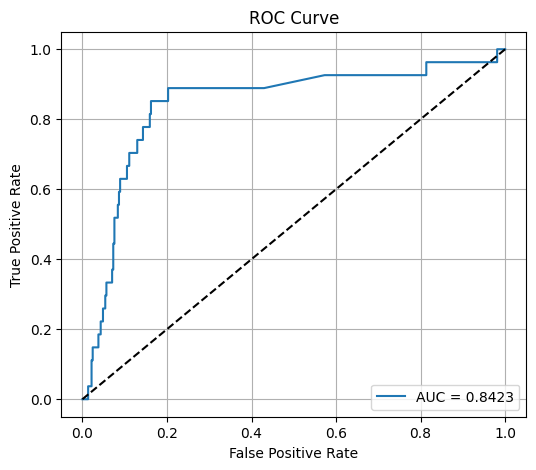

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Precision-Recall Curve

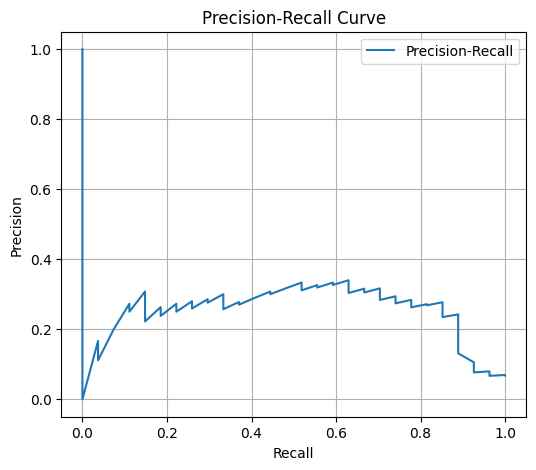

In [52]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(Y_val, y_val_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

Model Loss and Accuracy Curve

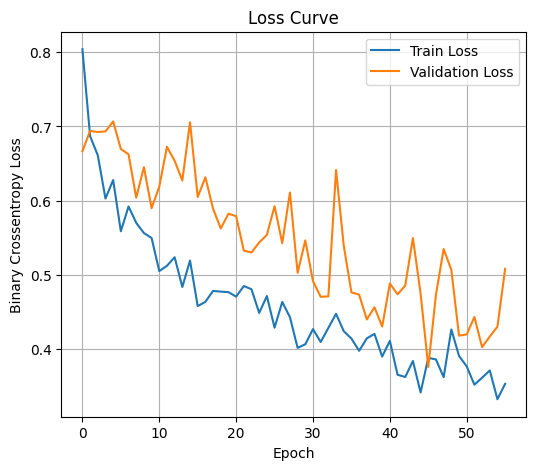

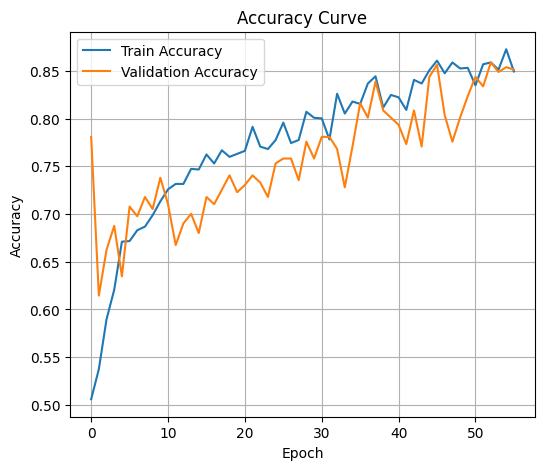

In [53]:
if 'loss' in best_model.history.history:
    history = best_model.history.history

    # Plot Loss Curve
    plt.figure(figsize=(6, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy Curve
    if 'accuracy' in history and 'val_accuracy' in history:
        plt.figure(figsize=(6, 5))
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Accuracy metrics not found in model history.")
else:
    print("Loss curve not available from best_model.history. Please re-train with `model.fit(..., return_history=True)` or track loss manually.")


In [62]:
# Save the best model
best_model.save('best_fnn_model.keras')

Prediction for FNN model on testing dataset

In [63]:
X_test = pd.read_csv('datasets/tabular_test_data.csv')
X_test.shape

bidder_id = X_test['bidder_id']
X_test = X_test.drop(['bidder_id'], axis=1)
print(f"X_test head: {X_test.head()}")

X_test head:    num_bids  num_countries  num_merchandise  num_urls   num_ips  num_devices  \
0 -0.105185      -0.525142        -0.022456 -0.128930 -0.140742    -0.408146   
1 -0.105117      -0.525142        -0.022456 -0.128557 -0.140324    -0.402817   
2 -0.103961      -0.525142        -0.022456 -0.126688 -0.138863    -0.376177   
3 -0.100695      -0.397105        -0.022456 -0.128183 -0.138863    -0.386833   
4  0.638939       2.547754        -0.022456  0.594453  0.266423     2.341159   

   num_auctions  total_duration  
0     -0.418184       -0.971005  
1     -0.404603        1.063659  
2     -0.336700        1.384308  
3     -0.391022       -0.633051  
4      2.345457        1.413016  


In [ ]:
# Generate predicted probabilities on the test set
y_pred_proba = best_model.predict(X_test).flatten()

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


In [ ]:
# Convert predicted probabilities into a pandas Series for easy viewing and export
y_pred_series = pd.Series(y_pred_proba.reshape(-1), name='prediction') 
y_pred_series

0       0.106663
1       0.015295
2       0.022197
3       0.085653
4       0.643192
          ...   
4625    0.113076
4626    0.314556
4627    0.539080
4628    0.107843
4629    0.639668
Name: prediction, Length: 4630, dtype: float32

In [67]:
# Combine with bidder_id into one DataFrame
submission_df = pd.concat([bidder_id.reset_index(drop=True), y_pred_series.reset_index(drop=True)], axis=1)


In [ ]:
na_bidders = pd.read_csv('datasets/bidder_ids_na.csv')  
na_bidders['prediction'] = 0.0  # Assign default outcome

In [69]:
# Merge with main predictions
final_df = pd.concat([submission_df, na_bidders], axis=0, ignore_index=True)
print(f"Final submission DataFrame shape: {final_df.shape}")
print(f"head of final DataFrame:\n{final_df.head()}")


Final submission DataFrame shape: (4700, 2)
head of final DataFrame:
                               bidder_id  prediction
0  002d229ffb247009810828f648afc2ef593rb    0.106663
1  003180b29c6a5f8f1d84a6b7b6f7be57tjj1o    0.015295
2  00486a11dff552c4bd7696265724ff81yeo9v    0.022197
3  0051aef3fdeacdadba664b9b3b07e04e4coc6    0.085653
4  0053b78cde37c4384a20d2da9aa4272aym4pb    0.643192


In [ ]:
# Save final CSV
final_df.to_csv('FNN_submission.csv', index=False)
print("Final CSV saved as: FNN_submission.csv")


Final CSV saved as: FNN_submission.csv
